### In this notebook we will learn:

* Getting Data: How to import data from PyCaret repository
* Setting up the sqlite database: To store the model artifacts, it is important to have a persistent database through sqlite.
* Setting up Environment: How to setup an experiment in PyCaret and get started with building classification models
* Create & Compare Models: How to create and compare various models, perform stratified cross validation and evaluate classification metrics
* Predict Model: How to make predictions on new / unseen data

In [35]:
#make sure your path is set to source folder
%cd /home

/home


In [36]:
!pwd

/home


## Loading Data 

### 1.1 Importing packages

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Imported Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import utils
from pycaret.classification import *
# Other Libraries
import mlflow

In [39]:
# Setting up all directory
root_folder = "/home/"
data_directory = root_folder+"data/raw/"
data_profile_path = root_folder+"/data/profile_report/"
intermediate_data_path = root_folder+"data/interim/"
database_path = root_folder+"database/"
print("directory loaded")

directory loaded


 ### 1.2 Reading the merged data

In [40]:
%%time
interim_data = "final_train_data_interim_1684433933.csv" # set the data recieved from the previous notebook
dataset = utils.load_data( [f"{intermediate_data_path}{interim_data}",
                            ]
                         )[0] #since we are only loading single data, we can access it with index 0, since it return multiple dfs in list
dataset.shape

CPU times: user 600 ms, sys: 52 ms, total: 652 ms
Wall time: 661 ms


(324000, 22)

In [41]:
dataset.head()

,msno,city,bd,gender,registered_via,registration_init_time,is_churn,payment_method_id,payment_plan_days,plan_list_price,...,is_cancel,transaction_date,membership_expire_date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,/7XuYVGXYHPggWsdtok0JEurQ10CtUO1Y8dDgy1/B0M=,1,0,others,7,2016-12-23,0,41.0,30.0,149.0,...,0.0,2017-02-22,2017-03-22,0.000000,0.000000,0.0,0.000000,2.289867,2.289867,7.810
1,gB3/kawEQSauWFArU9Z0kZo+ikw9GqJv0rXqNbpVnTY=,1,0,others,7,2016-12-23,0,41.0,30.0,99.0,...,0.0,2017-02-23,2017-03-23,0.274653,0.000000,0.0,0.000000,2.845647,2.281930,8.360
2,2aFAPs3QmxD+bNcCe8beuWcI7SZHg1k+1irALOxiw3k=,15,23,female,4,2016-12-24,0,40.0,30.0,149.0,...,0.0,2017-02-27,2017-03-26,0.000000,0.000000,0.0,0.000000,4.708342,4.683700,10.234
3,FjEZAhwFky8sWoaNGTp+p/r3/hH30WxLr396iSho3gs=,1,0,others,7,2016-12-25,0,41.0,30.0,99.0,...,0.0,2017-02-24,2017-03-24,0.621227,0.173287,0.0,0.346574,3.070758,2.640511,8.630
4,C5PNTuQxUQmHOXPptQnokhqH1XQoAHHL8pMWIX0nAh0=,1,0,others,7,2016-12-25,0,41.0,30.0,99.0,...,0.0,2017-02-24,2017-03-24,0.000000,0.000000,0.0,0.000000,1.595831,1.499937,7.082


 ### 1.3 Splitting the data to seen and unseen

In [29]:
# this function is also available in utils.py 
# def get_validation_unseen_set(dataframe, validation_frac=0.05, sample=False, sample_frac=0.1):
#     if not sample:
#         dataset = dataframe.copy()
#     else:
#         dataset = dataframe.sample(frac=sample_frac)
#     data = dataset.sample(frac=(1-validation_frac), random_state=786)
#     data_unseen = dataset.drop(data.index)
#     data.reset_index(inplace=True, drop=True)
#     data_unseen.reset_index(inplace=True, drop=True)
#     return data, data_unseen

In [43]:
data_for_model, data_unseen = utils.get_validation_unseen_set(dataset, validation_frac=0.05, sample=True, sample_frac=0.3)
print('Data for Modeling: ' + str(data_for_model.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (92340, 22)
Unseen Data For Predictions: (4860, 22)


In [44]:
data_for_model.head()

,msno,city,bd,gender,registered_via,registration_init_time,is_churn,payment_method_id,payment_plan_days,plan_list_price,...,is_cancel,transaction_date,membership_expire_date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,UWT31GQmak+tvcdkbXvoAoGSIyNKckzF4id++cnik9I=,1,0,others,7,2016-07-18,0,41.000000,30.000000,99.000000,...,0.0,2017-02-18,2017-03-18,1.298239,0.447940,0.447940,0.402359,1.196873,2.389809,7.270
1,y6HomQmu6MR0qO9XyVT5mtZODkR3ZHe6RzEmn6gbiFs=,18,22,male,3,2015-07-16,0,29.857143,26.714286,154.285714,...,0.0,2017-02-11,2017-03-11,1.634160,0.669174,0.456720,0.849928,3.128621,3.018273,8.695
2,ENkMk+/XJv0OmyJIcSh9OsGeye38Y1gjAvGSrFx3pVc=,4,19,male,4,2016-06-27,0,30.200000,25.400000,144.000000,...,0.0,2017-01-18,2017-03-11,1.631411,0.086643,0.346574,0.173287,2.954802,2.991342,8.570
3,QCc4guhKcQjki7NGQHorvqYmUngawa4H83baab+HuZo=,1,0,others,7,2015-09-27,0,41.000000,30.000000,99.000000,...,0.0,2017-02-27,2017-03-27,1.181874,0.377437,0.341964,0.270003,3.090743,3.431671,8.600
4,ouh2hYsit3zBt4pHNz80zxTMjLkAIEMhopU36sKRooo=,14,17,male,3,2016-06-04,0,29.111111,30.000000,149.888889,...,0.0,2017-02-13,2017-03-15,0.831704,0.611411,0.057762,0.264838,1.878985,2.468408,7.720


### 2 Setting up the sqlite database

In [32]:
# this function is also available in utils.py 

#create a sqlite db fo storing all the model artifacts etc
# import sqlite3
# from sqlite3 import Error

# def create_sqlit_connection(db_path,db_file):
#     """ create a database connection to a SQLite database """
#     conn = None
#     # opening the conncetion for creating the sqlite db
#     try:
#         conn = sqlite3.connect(db_path+db_file)
#         print(sqlite3.version)
#     # return an error if connection not established
#     except Error as e:
#         print(e)
#     # closing the connection once the database is created
#     finally:
#         if conn:
#             conn.close()

In [45]:
utils.create_sqlit_connection(database_path,r"mlflow_v01.db")

2.6.0


In [46]:
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [35]:
# do not go ahead unless you execute this step and mlflow is isntalled. 
 
#MAKE mlruns FOLDER on root folder
#run this on terminal where you are on root folder. 
# Makse sure to point the database to correct address. Assuming you have same folder structure you can use this
#mlflow server --backend-store-uri='sqlite:///database/mlflow_v01.db' --default-artifact-root="mlruns/" --port=6006 --host=0.0.0.0

In [36]:
#pip install pycaret==2.3.8

### 3 Setting up Environment: 

The `setup()` function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. `setup()`must be called before executing any other function in pycaret. 
* It takes two mandatory parameters: a pandas dataframe and the name of the target column. 
* All other parameters are optional and are used to customize the pre-processing pipeline (we will see them in later tutorials).

When `setup()` is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In [47]:
# No Pre-Processing 
Baseline_model_exp01 = setup(data = data_for_model, target = 'is_churn', 
                   session_id = 42,fix_imbalance=False,ignore_features=['msno'],
                   date_features=['registration_init_time','transaction_date','membership_expire_date'],
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp01',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,is_churn
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(92340, 22)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [49]:
# this function is also available in utils.py 
def get_train_test_set_from_setup():
    return get_config(variable="X_train"),\
            get_config(variable="y_train"),\
            get_config(variable="X_test"),\
            get_config(variable="y_test")

def get_x_y_from_setup():
    return get_config(variable="X"),\
            get_config(variable="y")

def get_transformation_pipeline_from_setup():
    return get_config(variable="prep_pipe")

In [50]:
X_train, y_train, X_test, y_test = get_train_test_set_from_setup()
#you can also get X,y
# X,y = utils.get_x_y_from_setup()
X_train.head()

,city,bd,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,is_cancel,num_25,num_50,num_75,...,membership_expire_date_month_3,membership_expire_date_weekday_0,membership_expire_date_weekday_1,membership_expire_date_weekday_2,membership_expire_date_weekday_3,membership_expire_date_weekday_4,membership_expire_date_weekday_5,membership_expire_date_weekday_6,membership_expire_date_is_month_end_0,membership_expire_date_is_month_start_1
77394,1.0,0.0,41.0,30.0,99.000,1.0,0.0,0.173287,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
86781,9.0,39.0,41.0,30.0,99.000,1.0,0.0,0.385862,0.068663,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41071,1.0,0.0,36.0,30.0,180.000,1.0,0.0,0.000000,0.000000,0.000000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25689,1.0,0.0,41.0,30.0,99.000,1.0,0.0,0.415297,0.216212,0.077016,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
22515,6.0,24.0,36.0,30.0,166.875,0.0,0.0,1.044375,0.207076,0.207076,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
pipeline = get_transformation_pipeline_from_setup()
pipeline

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['msno'], id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='is_churn',
                                      time_features=['registration_init_time',
                                                     'transaction_date',
                                                     'membership_expire_date'])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_a...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='is_churn')),
                ('fix_per

In [53]:
# p = get_config(variable="prep_pipe")
# p.fit_transform(get_config(variable="data_before_preprocess"))

In [ ]:
# models(internal=True)[['Name', 'GPU Enabled']]

### 4 Compare models: 

In [60]:
best_model = compare_models(fold = 5) #exclude=['xgboost']

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9564,0.9733,0.6767,0.6709,0.6733,0.6500,0.6503,1.0520
rf,Random Forest Classifier,0.9560,0.9722,0.6262,0.6851,0.6540,0.6306,0.6315,8.2000
gbc,Gradient Boosting Classifier,0.9560,0.9677,0.6937,0.6613,0.6769,0.6533,0.6536,16.3000
et,Extra Trees Classifier,0.9549,0.9738,0.6080,0.6792,0.6414,0.6174,0.6186,6.6720
lda,Linear Discriminant Analysis,0.9523,0.9271,0.7470,0.6169,0.6756,0.6502,0.6537,0.6560
ada,Ada Boost Classifier,0.9503,0.9584,0.6171,0.6283,0.6225,0.5959,0.5960,4.0800
ridge,Ridge Classifier,0.9502,0.0000,0.5233,0.6573,0.5824,0.5563,0.5605,0.0680
lr,Logistic Regression,0.9499,0.9336,0.5556,0.6428,0.5958,0.5693,0.5711,9.6260
dt,Decision Tree Classifier,0.9431,0.7774,0.5864,0.5695,0.5777,0.5472,0.5473,0.7980
svm,SVM - Linear Kernel,0.9426,0.0000,0.4813,0.5916,0.4970,0.4700,0.4862,1.0220


* Two simple words of code (not even a line) have created over 15 models using 10 fold stratified cross validation and evaluated the 6 most commonly used classification metrics (Accuracy, AUC, Recall, Precision, F1, Kappa). 

* The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using 'Accuracy' (highest to lowest) which can be changed by passing the sort parameter. For example compare_models(sort = 'Recall') will sort the grid by Recall instead of Accuracy. 

* If you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For example compare_models(fold = 5) will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time.

In [61]:
#selecting the best model
lgbm  = create_model('lightgbm', fold = 5) 

In [62]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### 5 Analyzing the model performance

5.1 Learning Curve

In [63]:
%matplotlib inline

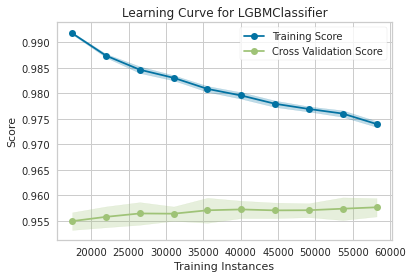

In [64]:
plot_model(lgbm, plot = 'learning')

5.2 ROC Curve

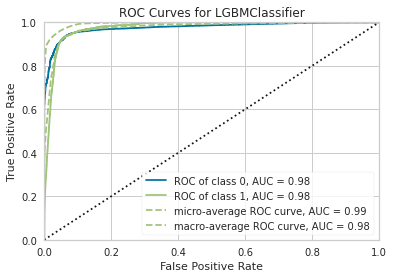

In [65]:
plot_model(lgbm, plot = 'auc')

5.3 Precision-recall Curve

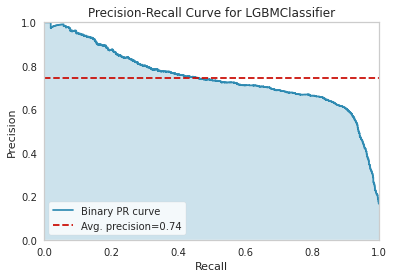

In [66]:
plot_model(lgbm, plot = 'pr')

5.4 Confusion Matrix

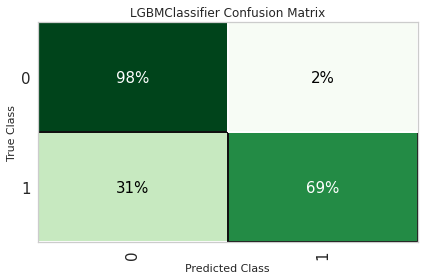

In [67]:
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

5.5 Feature Importance

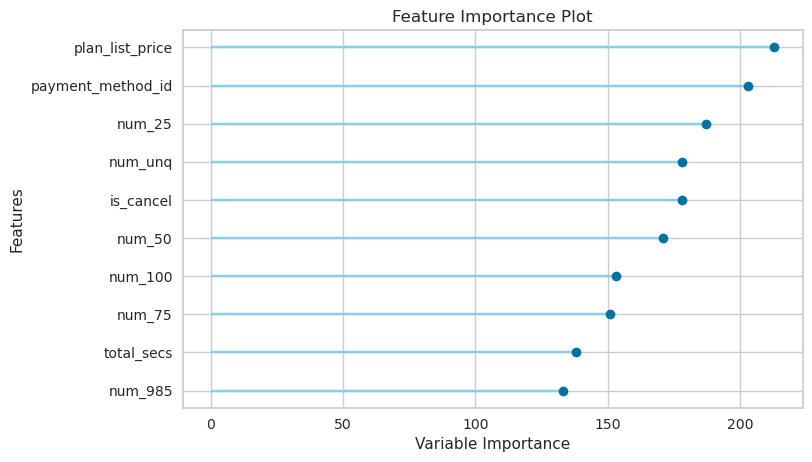

In [68]:
#top 10 features
plot_model(lgbm, plot='feature') #feature_all -> to check for all features 

5.6 Prediction class distribution

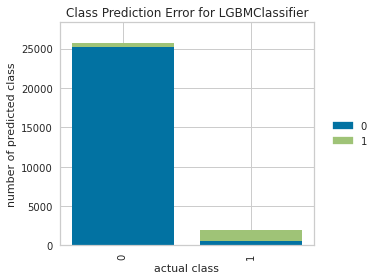

In [69]:
plot_model(lgbm, plot='error')

5.7 Model Interpretability

In [71]:
#pip install shap

     |████████████████████████████████| 575 kB 581 kB/s eta 0:00:01


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


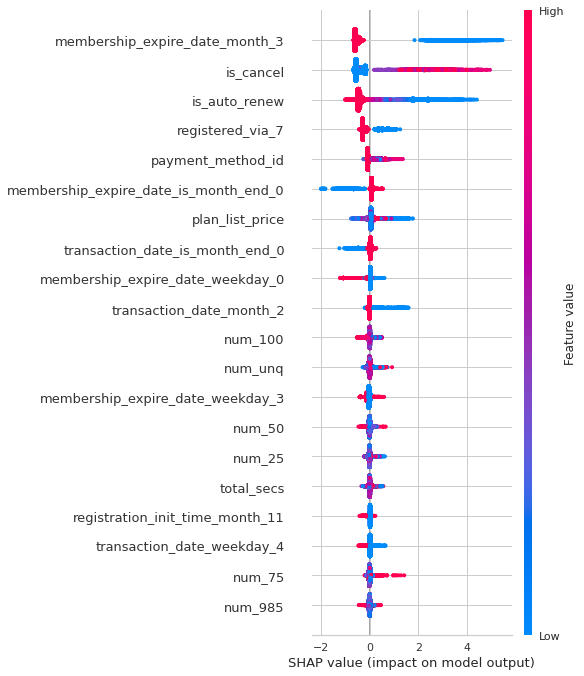

In [72]:
# interpret model
interpret_model(lgbm)

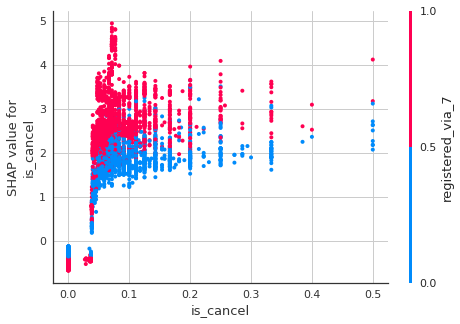

In [73]:
interpret_model(lgbm,plot='correlation',feature='is_cancel')

In [74]:
interpret_model(lgbm,plot='reason',observation=0) # index of observation in test data

In [79]:
#pip install interpret

In [80]:
# interpret_model(lgbm,plot='msa')

5.8 Model Evaluation

In [78]:
predict_model(lgbm, data_unseen);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9066,0.6344,0.1356,0.1674,0.1498,0.1010,0.1016
